In [220]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Reds'

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

In [2]:
img_rows, img_cols = 28, 28
num_classes = 10

df = pd.read_csv('train.csv')
print(df.shape)

y = df.label

X = df.drop('label',axis=1)
X = X/255
X = X.values.reshape(len(X),img_rows,img_cols,1)


del df

(42000, 785)


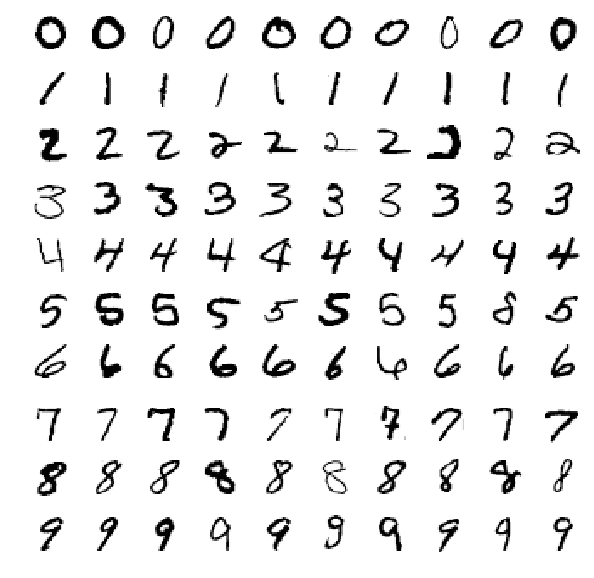

In [3]:
plt.figure(figsize=(10,10))
for i in range(10):
    tmp = X[y==i]
    for j in range(10):
        plt.subplot(10,10,(10*i)+(j+1))
        plt.imshow(tmp[j][:,:,0], cmap='Greys')
        plt.clim(0,1)
        plt.axis('off')

In [4]:
y = keras.utils.to_categorical(y, num_classes)
print(y.shape)
print(y[0])

(42000, 10)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [226]:
n_filters = 12

model = Sequential()
model.add(Conv2D(n_filters, kernel_size=(3, 3), activation='relu',
                 input_shape=(img_rows, img_cols, 1),name='conv1'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, name='pool1'))
model.add(Conv2D(n_filters, kernel_size=(3, 3), activation='relu',name='conv2'))
model.add(Flatten())
model.add(Dense(50, activation='relu',name='dense1'))
model.add(Dense(num_classes, activation='softmax',name='dense2'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y,
          batch_size=100,
          epochs=3,
          validation_split = 0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 22s 651us/step - loss: 0.3977 - acc: 0.8843 - val_loss: 0.1452 - val_acc: 0.9595
Epoch 2/3
33600/33600 [==============================] - 21s 617us/step - loss: 0.1150 - acc: 0.9665 - val_loss: 0.0926 - val_acc: 0.9724
Epoch 3/3
33600/33600 [==============================] - 21s 632us/step - loss: 0.0770 - acc: 0.9779 - val_loss: 0.0687 - val_acc: 0.9756


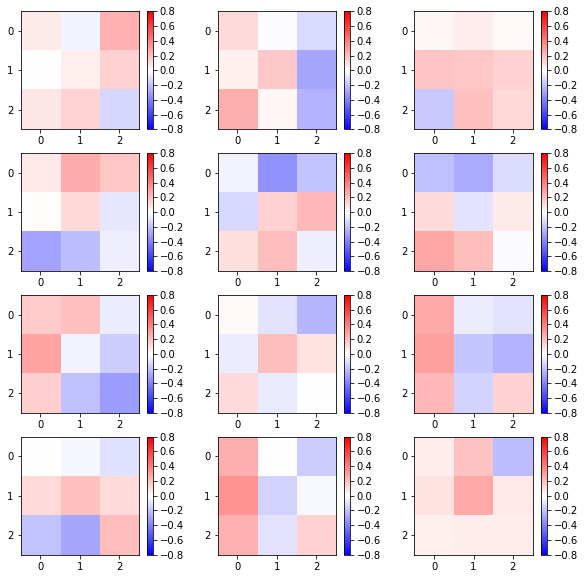

In [6]:
tmp=model.get_layer('conv1').get_weights()[0]
plt.figure(figsize=(10,10))
for i in range(n_filters):
    plt.subplot(4,3,i+1)
    plt.imshow(tmp[:,:,0,i],cmap='bwr')
    plt.clim(-0.8,0.8)
    plt.colorbar()

In [227]:
model_conv1=Sequential()
model_conv1.add(model.get_layer('conv1'))
model_conv1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
conv1_out = model_conv1.predict(X)
print(conv1_out.shape)

model_conv2=Sequential()
model_conv2.add(model.get_layer('pool1'))
model_conv2.add(model.get_layer('conv2'))
model_conv2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
conv2_out = model_conv2.predict(conv1_out)
print(conv2_out.shape)

model_dense1=Sequential()
model_dense1.add(Flatten())
model_dense1.add(model.get_layer('dense1'))
model_dense1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
dense1_out = model_dense1.predict(conv2_out)
print(dense1_out.shape)

model_dense2=Sequential()
model_dense2.add(Flatten())
model_dense2.add(model.get_layer('dense2'))
model_dense2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model_out = model_dense2.predict(dense1_out)

#model_out = model.predict(X)
print(model_out.shape)

(42000, 26, 26, 12)
(42000, 11, 11, 12)
(42000, 50)
(42000, 10)


In [224]:
def plot_network(img_id):
    plt.figure(figsize=(24,9))

    # title for input layer
    ax = plt.subplot(5,n_filters+1,1)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'INPUT', verticalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    # title for 1st Conv2d layer
    ax = plt.subplot(5,n_filters+1,n_filters+2)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'CONV1', verticalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    # title for 2nd Conv2d layer
    ax = plt.subplot(5,n_filters+1,2*n_filters+3)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'CONV2', verticalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')
    
    # title for 1st dense layer
    ax = plt.subplot(5,n_filters+1,3*n_filters+4)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'DENSE', verticalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    # title for output layer
    ax = plt.subplot(5,n_filters+1,4*n_filters+5)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'OUTPUT', verticalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    # show input image
    plt.subplot2grid((5, n_filters+1), (0, int(n_filters/3)+2), colspan=int(n_filters/3)-2)
    plt.imshow(X[img_id][:,:,0])
    plt.clim(0,1)
    plt.axis('off')
    
    # label of input image
    ax = plt.subplot2grid((5, n_filters+1), (0, 2), colspan=3)
    plt.plot([0,0],[1,1])
    ax.text(0,1,
            'True label: '+str(y[img_id,:].argmax()),
            verticalalignment='center',horizontalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    # network prediction for input image
    ax = plt.subplot2grid((5, n_filters+1), (0, n_filters-3), colspan=3)
    plt.plot([0,0],[1,1])
    ax.text(0,1,
            'Predicted: '+str(model_out[img_id,:].argmax())+' ({:.1f}% probability)'.format(100*model_out[img_id,:].max()),
            verticalalignment='center',horizontalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    # show output of 1st Conv2d layer
    for i in range(n_filters):
        plt.subplot(5,n_filters+1,i+3+n_filters)
        plt.imshow(conv1_out[img_id,:,:,i])
        plt.axis('off')
        
    # show output of 2nd Conv2d layer
    for i in range(n_filters):
        plt.subplot(5,n_filters+1,i+4+2*n_filters)
        plt.imshow(conv2_out[img_id,:,:,i])
        plt.axis('off')

    # show output of 1st Dense layer
    plt.subplot2grid((5, n_filters+1), (3, 1), colspan=n_filters)
    plt.imshow(dense1_out[img_id,:].reshape(1,50),aspect=2) #4,32
    plt.axis('off')
    
    # show final network output
    plt.subplot2grid((5, n_filters+1), (4, 2), colspan=n_filters-2)
    plt.bar(range(10),model_out[img_id,:],width=1,color='r')
    plt.ylim(0,1)
    plt.xticks(range(10))
    plt.xlim(-0.5,9.5)

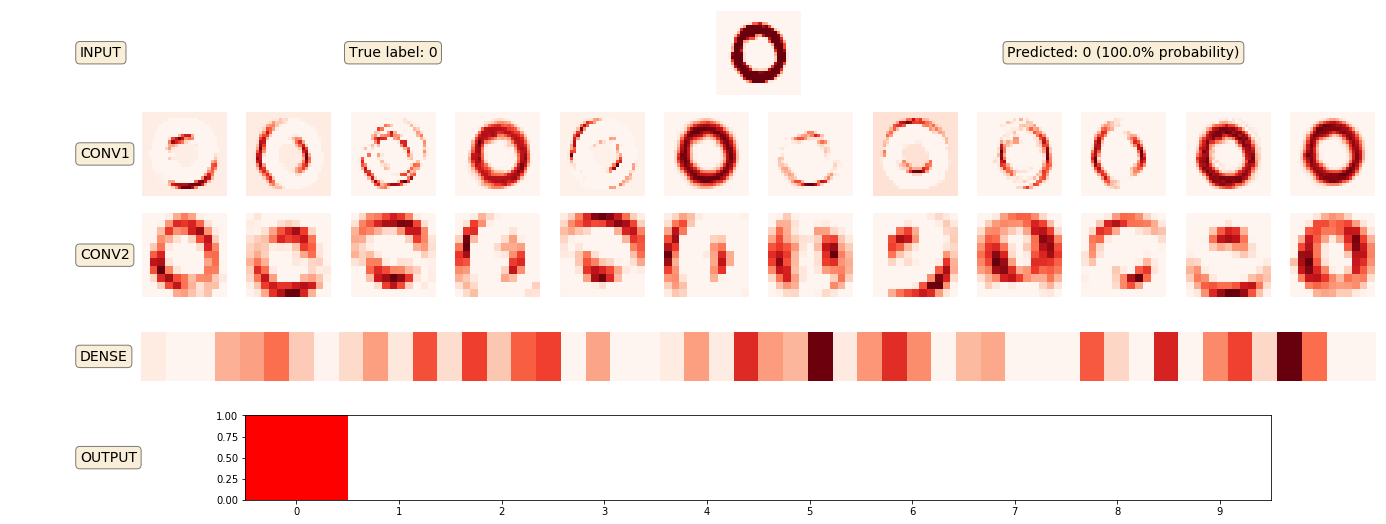

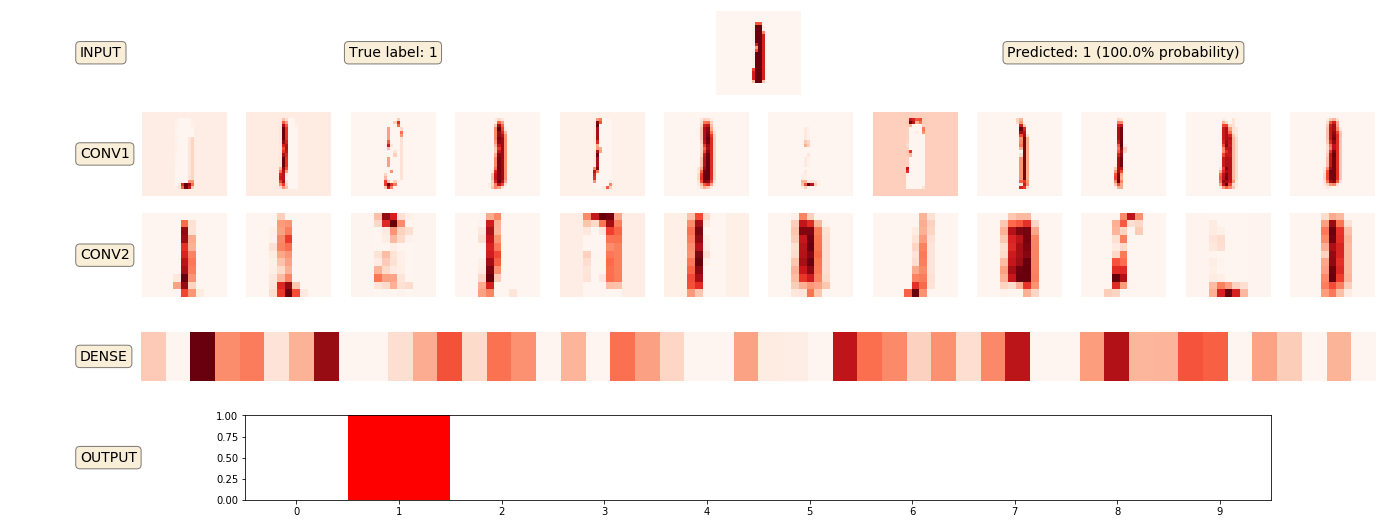

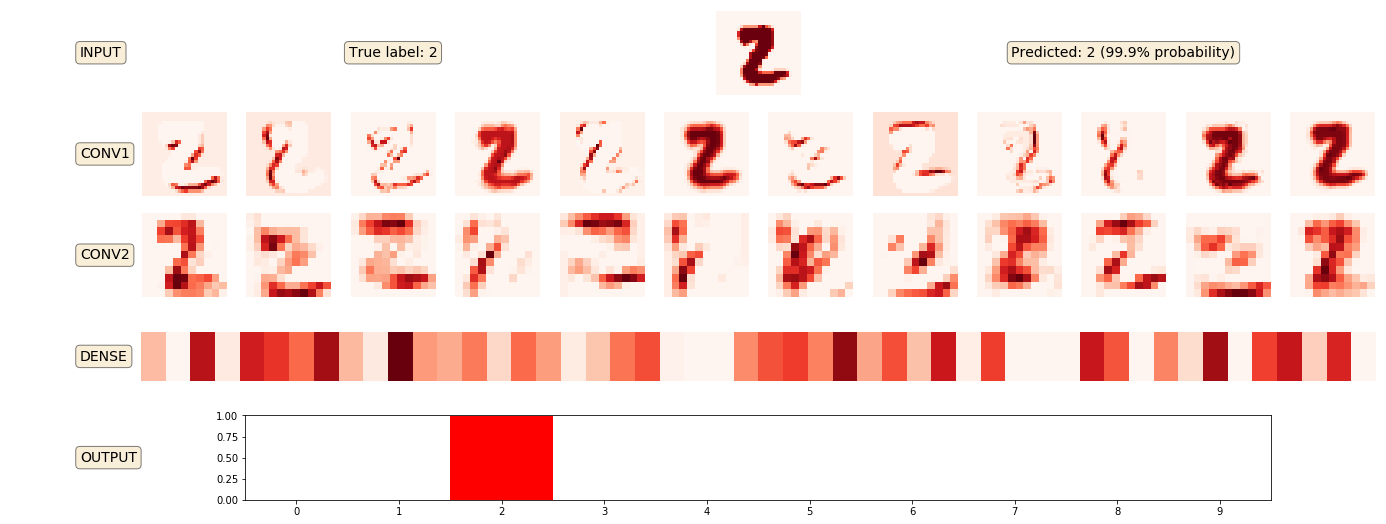

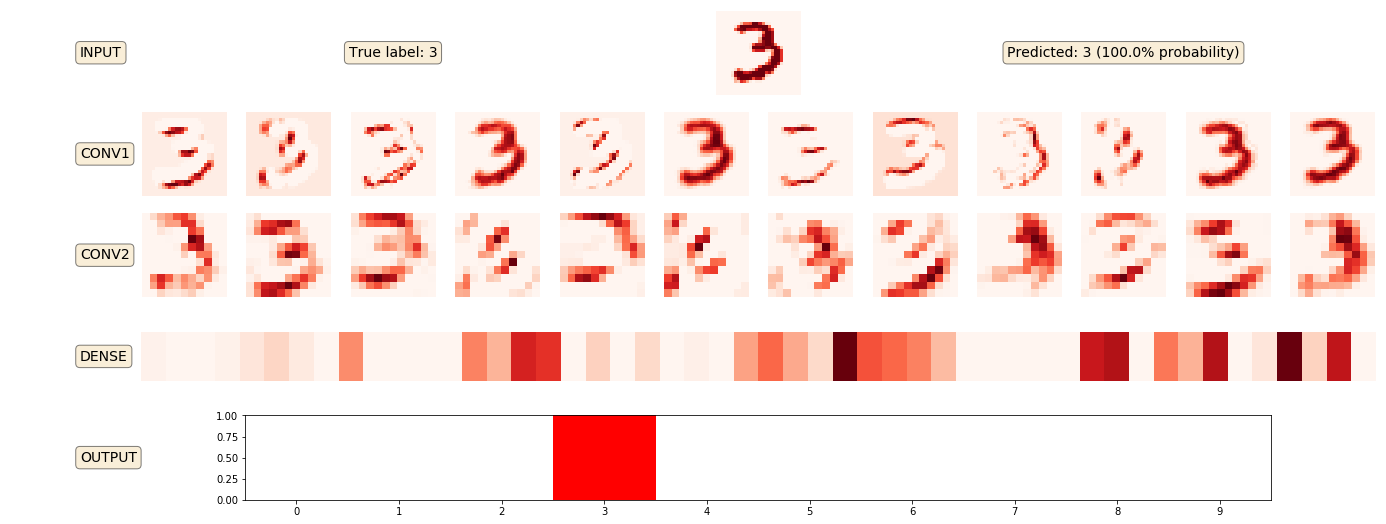

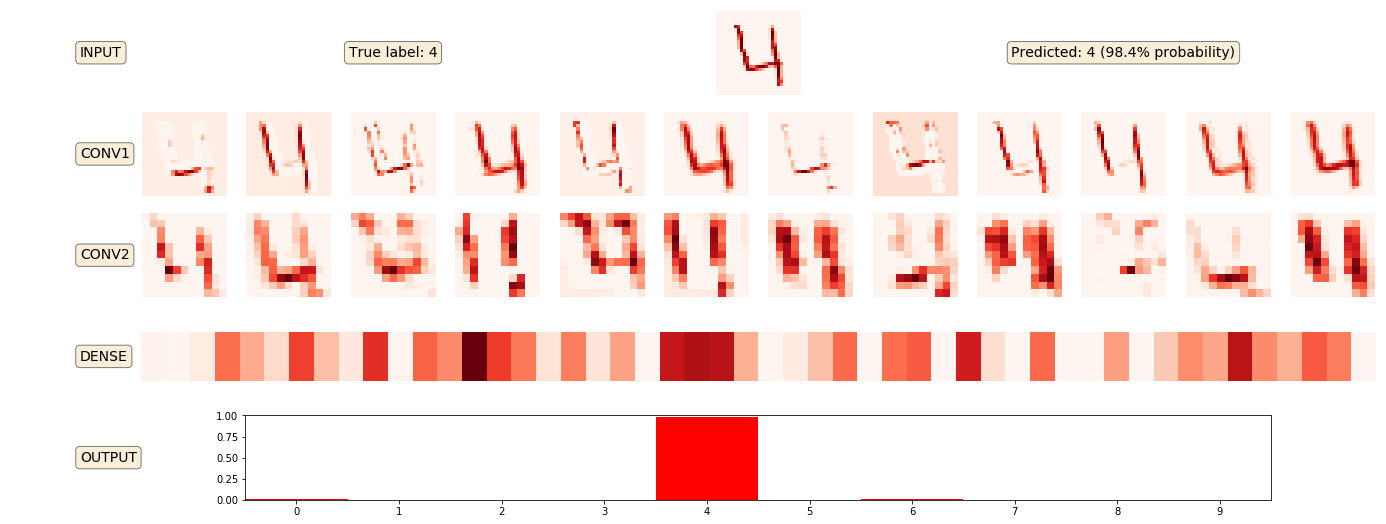

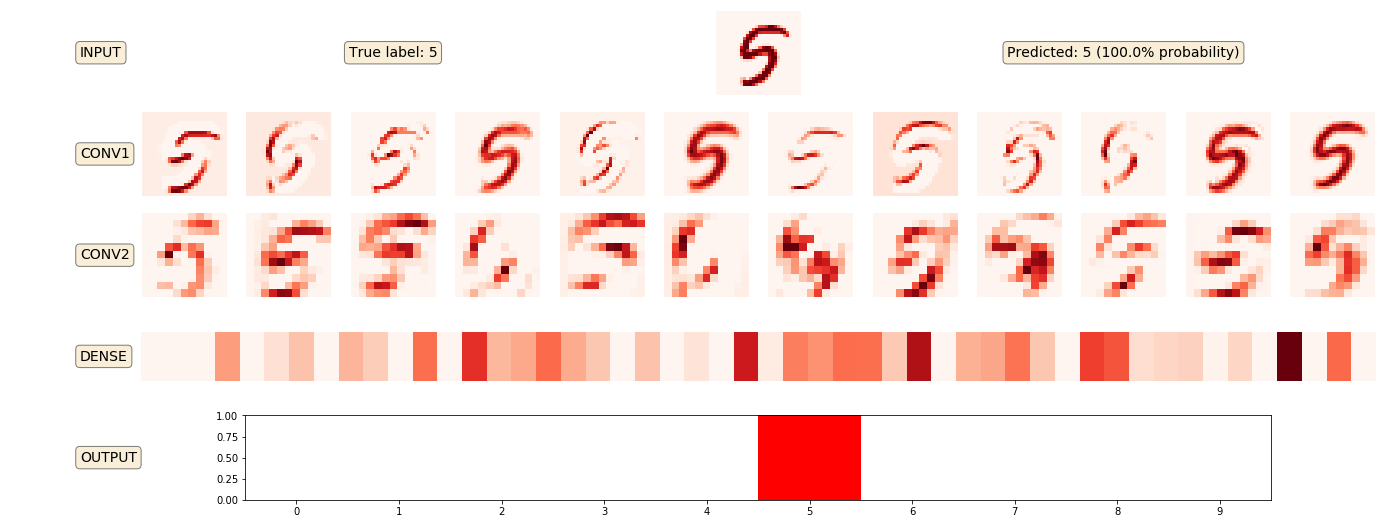

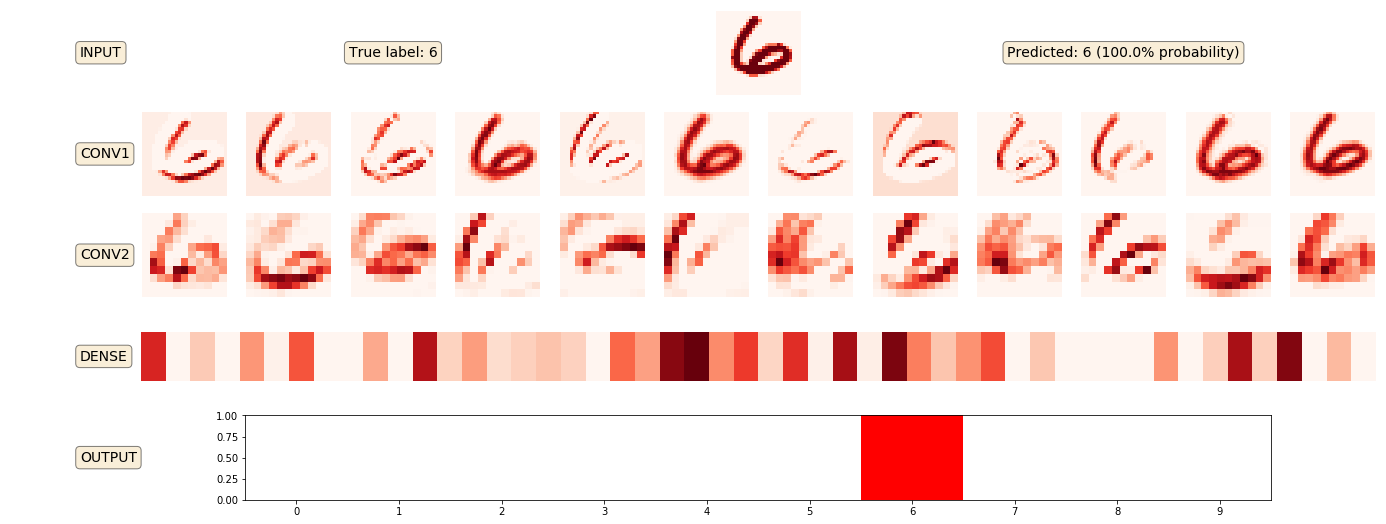

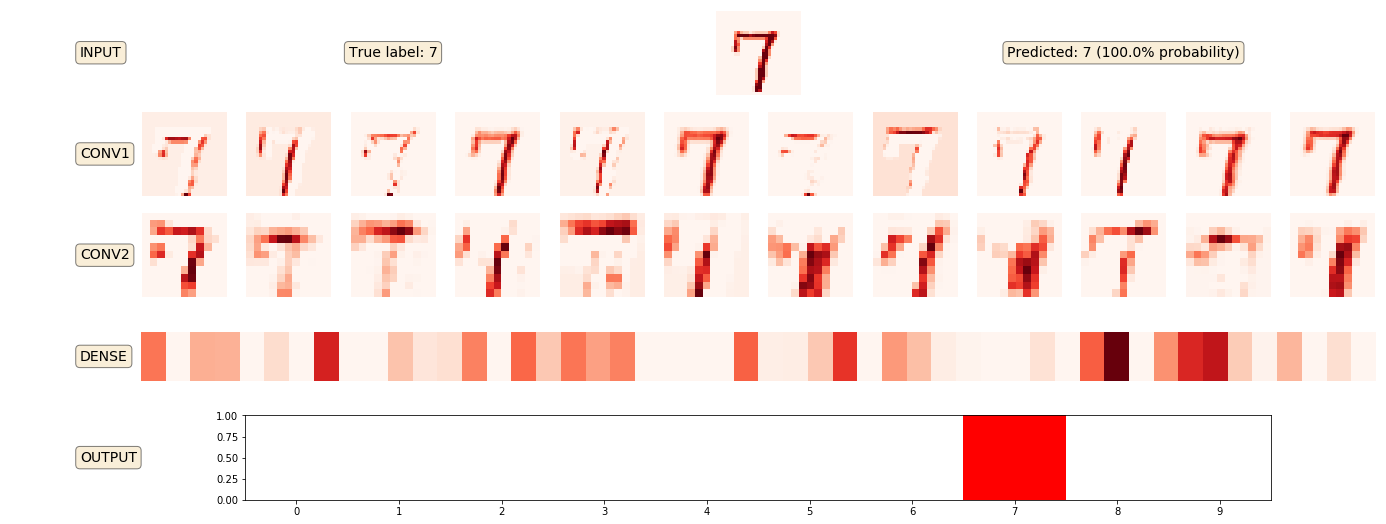

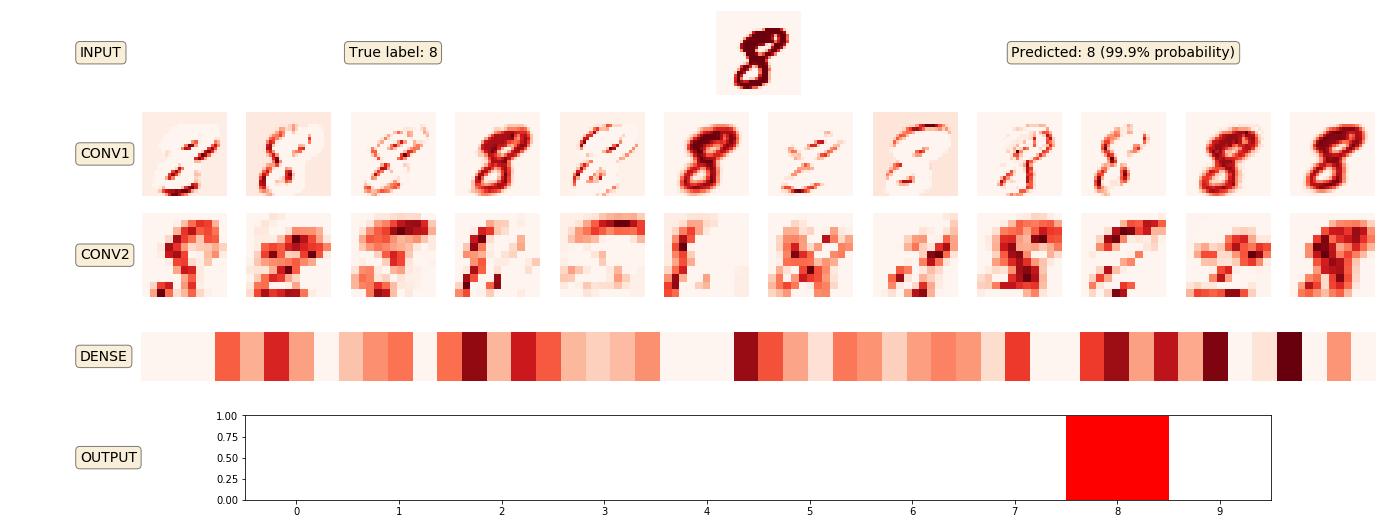

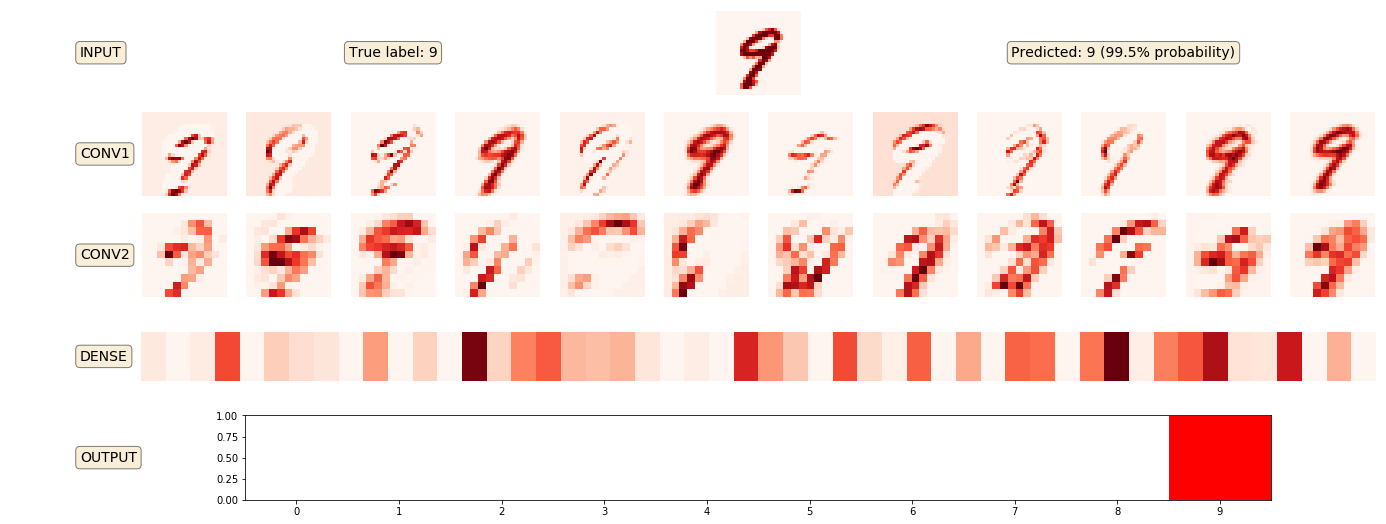

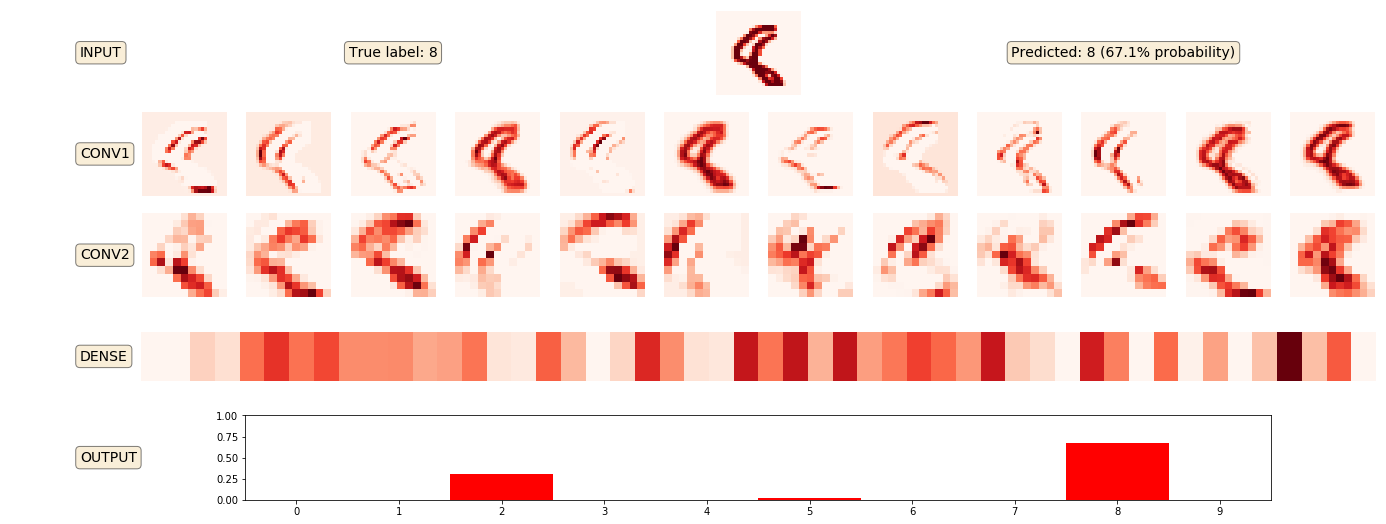

In [228]:
plot_imgs = [1,2,16,9,3,8,72,6,10,11,35348]

for img_id in plot_imgs:
    plot_network(img_id)

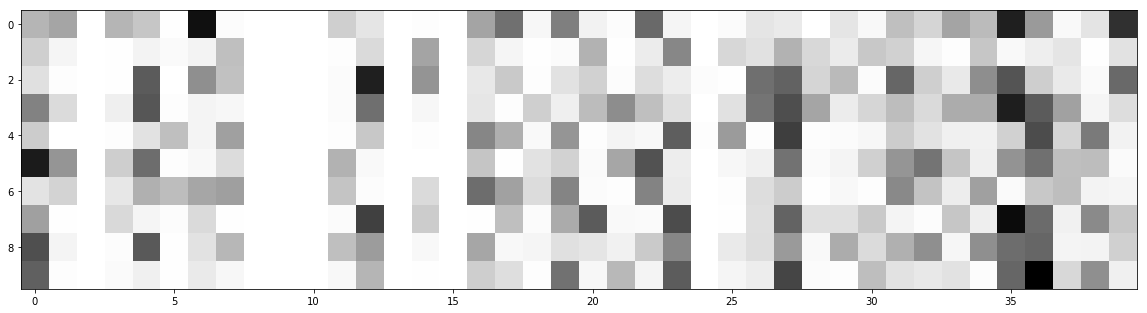

In [73]:
dense_numavg = np.empty([10,40])
for i in range(10):
    dense_numavg[i,:] = dense1_out[(y[:,i]==1),:].mean(axis=0)

plt.figure(figsize=(20,20))
plt.imshow(dense_numavg)

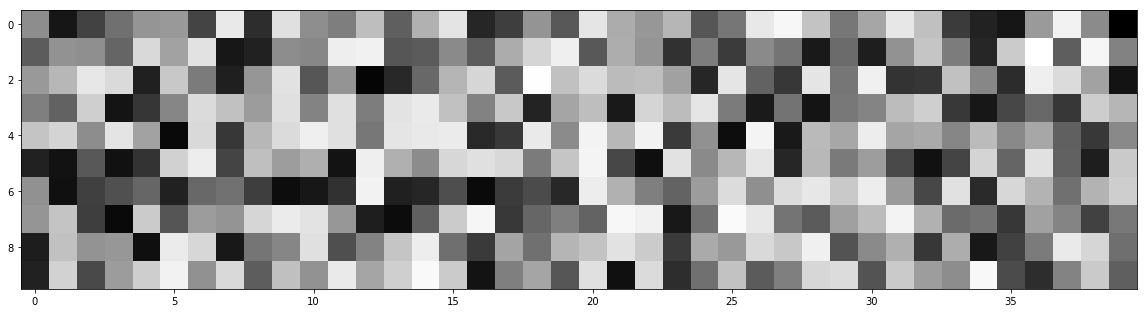

In [75]:
out_weights=model.get_layer('dense2').get_weights()[0].T
plt.figure(figsize=(20,20))
plt.imshow(out_weights)#*dense_numavg)

<Container object of 40 artists>

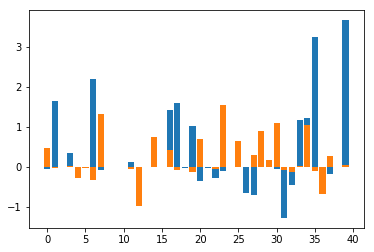

In [79]:
tmp = out_weights*dense_numavg
plt.bar(range(40),tmp[0])
plt.bar(range(40),tmp[1])

In [145]:
#plt.bar(range(10),model_out[img_id,:])
np.sort(model_out.max(axis=1))[4200]

0.95348287

(42000, 10)


([<matplotlib.axis.YTick at 0x1ba946b8cf8>,
 <a list of 10 Text yticklabel objects>)

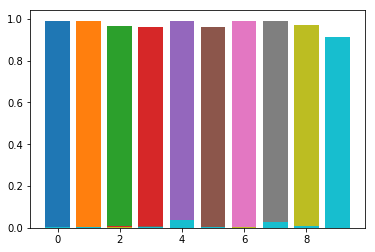

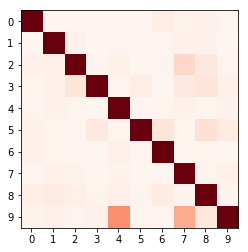

In [169]:
print(model_out.shape)
numavg = np.empty([10,10])
for i in range(10):
    numavg[i,:] = model_out[(y[:,i]==1),:].mean(axis=0)
    plt.bar(range(10),numavg[i,:])

plt.figure()
plt.imshow(numavg)
plt.clim(0,0.1)
plt.xticks(range(10))
plt.yticks(range(10))

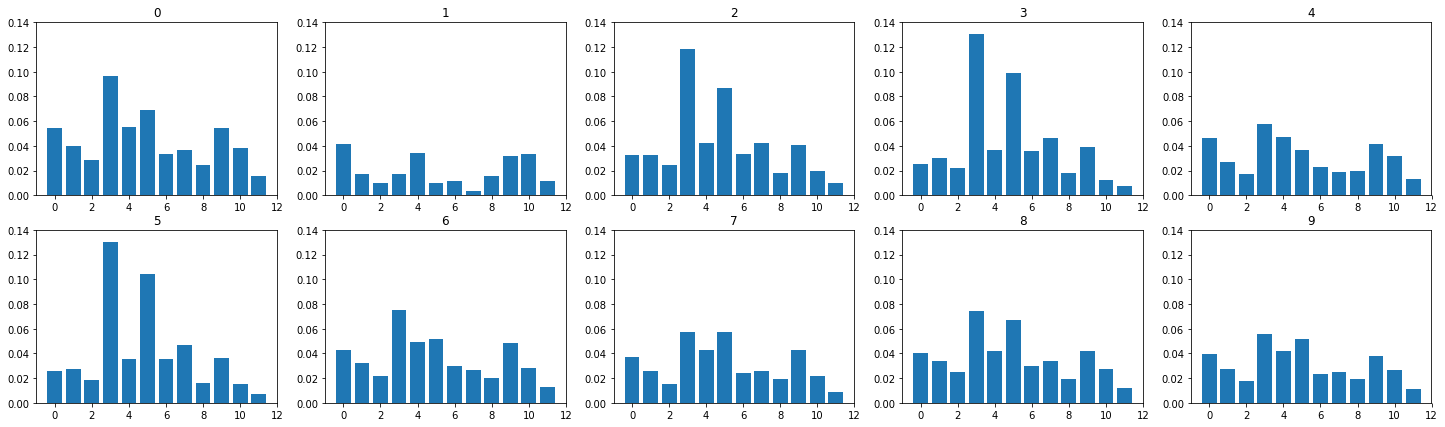

In [208]:
conv2_avg = np.empty([12,10])

for i in range(10):
    conv2_avg[:,i] = (conv2_out[y[:,i]==1,:,:,:]**2).mean(axis=(1,2)).mean(axis=0)

plt.figure(figsize=(25,7))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.bar(range(12),conv2_avg[:,i])
    plt.title(i)
    plt.ylim(0,0.14)

(-0.5, 9.5)

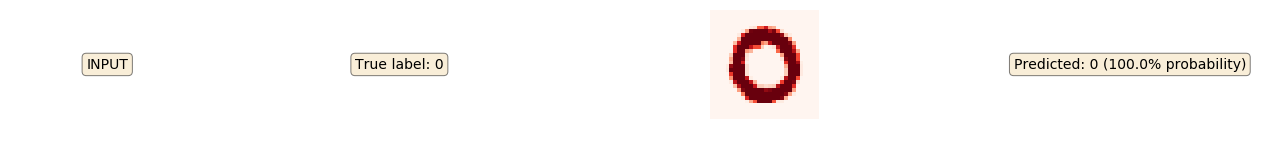

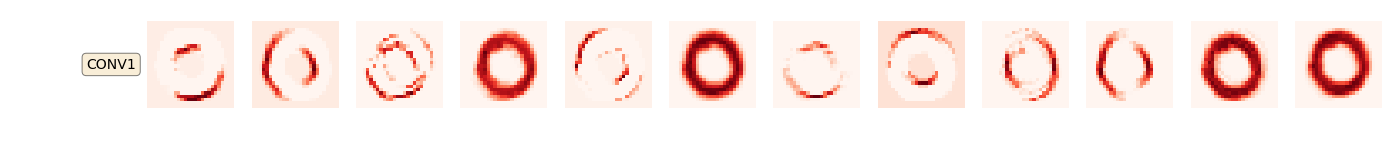

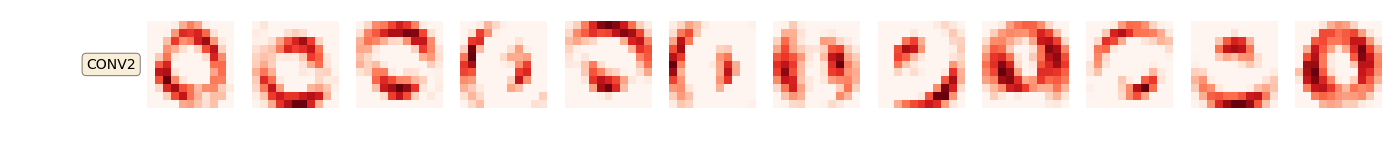

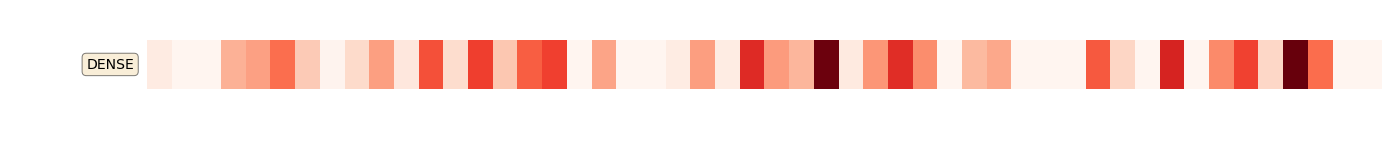

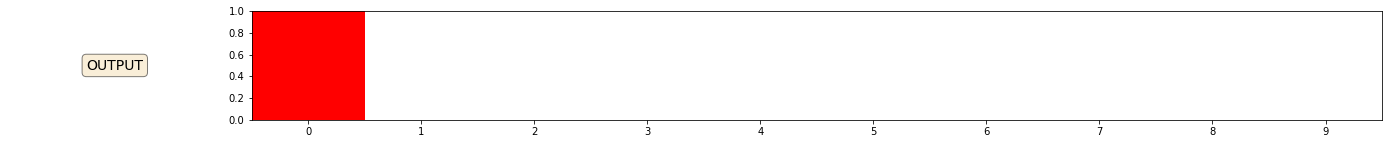

In [277]:
img_id = 1


# input layer
plt.figure(figsize=(24,2))

ax = plt.subplot(1,n_filters+1,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.plot([0,0],[1,1])
ax.text(0, 1, 'INPUT', verticalalignment='center',fontsize=14,bbox=props)
plt.axis('off')

# show input image
plt.subplot2grid((1, n_filters+1), (0, int(n_filters/3)+2), colspan=int(n_filters/3)-2)
plt.imshow(X[img_id][:,:,0])
plt.clim(0,1)
plt.axis('off')

# label of input image
ax = plt.subplot2grid((1, n_filters+1), (0, 2), colspan=3)
plt.plot([0,0],[1,1])
ax.text(0,1,
        'True label: '+str(y[img_id,:].argmax()),
        verticalalignment='center',horizontalalignment='center',fontsize=14,bbox=props)
plt.axis('off')

# network prediction for input image
ax = plt.subplot2grid((1, n_filters+1), (0, n_filters-3), colspan=3)
plt.plot([0,0],[1,1])
ax.text(0,1,
        'Predicted: '+str(model_out[img_id,:].argmax())+' ({:.1f}% probability)'.format(100*model_out[img_id,:].max()),
        verticalalignment='center',horizontalalignment='center',fontsize=14,bbox=props)
plt.axis('off')
##########################

plt.figure(figsize=(24,2))

# title for 1st Conv2d layer
ax = plt.subplot(1,n_filters+1,1)
plt.plot([0,0],[1,1])
ax.text(0, 1, 'CONV1', verticalalignment='center',fontsize=14,bbox=props)
plt.axis('off')

# show output of 1st Conv2d layer
for i in range(n_filters):
    plt.subplot(1,n_filters+1,i+2)
    plt.imshow(conv1_out[img_id,:,:,i])
    plt.axis('off')

##########################
plt.figure(figsize=(24,2))

# title for 2nd Conv2d layer
ax = plt.subplot(1,n_filters+1,1)
plt.plot([0,0],[1,1])
ax.text(0, 1, 'CONV2', verticalalignment='center',fontsize=14,bbox=props)
plt.axis('off')

# show output of 2nd Conv2d layer
for i in range(n_filters):
    plt.subplot(1,n_filters+1,i+2)
    plt.imshow(conv2_out[img_id,:,:,i])
    plt.axis('off')

##########################
plt.figure(figsize=(24,2))

# title for 1st dense layer
ax = plt.subplot(1,n_filters+1,1)
plt.plot([0,0],[1,1])
ax.text(0, 1, 'DENSE', verticalalignment='center',fontsize=14,bbox=props)
plt.axis('off')

# show output of 1st Dense layer
plt.subplot2grid((1, n_filters+1), (0, 1), colspan=n_filters)
plt.imshow(dense1_out[img_id,:].reshape(1,50),aspect=2) #4,32
plt.axis('off')

##########################
plt.figure(figsize=(24,2))

# title for output layer
ax = plt.subplot(1,n_filters+1,1)
plt.plot([0,0],[1,1])
ax.text(0, 1, 'OUTPUT', verticalalignment='center',fontsize=14,bbox=props)
plt.axis('off')

# show final network output
plt.subplot2grid((1, n_filters+1), (0, 2), colspan=n_filters)
plt.bar(range(10),model_out[img_id,:],width=1,color='r')
plt.ylim(0,1)
plt.xticks(range(10))
plt.xlim(-0.5,9.5)


(-0.5, 9.5)

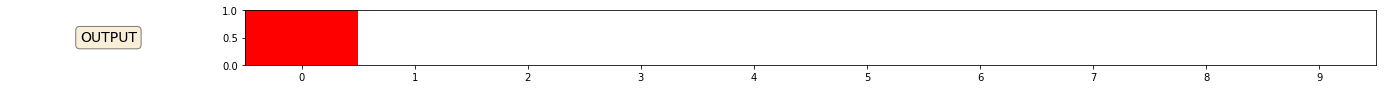

In [273]:
plt.figure(figsize=(24,1))

# title for output layer
ax = plt.subplot(1,n_filters+1,1)
plt.plot([0,0],[1,1])
ax.text(0, 1, 'OUTPUT', verticalalignment='center',fontsize=14,bbox=props)
plt.axis('off')

# show final network output
plt.subplot2grid((1, n_filters+1), (0, 2), colspan=n_filters)
plt.bar(range(10),model_out[img_id,:],width=1,color='r')
plt.ylim(0,1)
plt.xticks(range(10))
plt.xlim(-0.5,9.5)
#plt.gca().axes.get_yaxis().set_visible(False)